# Panel estimation of wildifire probability 

In [1]:
import pandas as pd
from tsraster.prep import combine_extracted_features, combine_target_rasters, wide_to_long_target_features,unmask_df,panel_lag_1
from tsraster.calculate import checkRelevance2
from numpy import NaN,isnan

import tsraster.prep  as tr
import tsraster.model  as md
import rasterio
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier

### Organize data

* Climate_feature_subset_train
    * 2001_2005
        * aet_features
            * extracted_features.csv
            * ...
        * ppt_features
            * extracted_features.csv
            * ...        
    * 2006_2010
        * aet_features
            * extracted_features.csv
            * ...
        * ppt_features
            * extracted_features.csv
            * ...  
    * 2011_2015

append all features to one dataframe

In [2]:

path = r'G:\Climate_feature_subset_train'

concatenated_attribute_df = combine_extracted_features(path,write_out=False)


Combining folder year names ['19861990', '19861990', '19861990', '19861990', '19861990', '19861990', '19911995', '19911995', '19911995', '19911995', '19911995', '19911995', '19962000', '19962000', '19962000', '19962000', '19962000', '19962000']


C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv2\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


collect multitple years of Y (target) data

In [3]:
path = r"G:\Fire_target_train"
target_file_prefix = 'fire_'

concatenated_target_df = combine_target_rasters(path,
                                                target_file_prefix,
                                                write_out=False)

mask both the attribute data and targets 

In [ ]:
raster_mask =u"F:/Boundary/StatePoly_buf.tif"
original_df = [concatenated_attribute_df, concatenated_target_df]

mask_attributes_df, mask_target_df = tr.mask_df(raster_mask, 
                                                original_df,  
                                                missing_value=-9999)

In [5]:

#def mask_df(raster_mask, original_df, missing_value = -9999):
'''
Reads in raster mask and subsets dataframe by mask index

:param raster_mask: tif containing (0,1) mask where 1's are retained
:param original_df: a path to a pandas dataframe, a series to mask, or a list of 2 dfs
:return: masked df
'''

# convert mask to pandas series
index_mask = image_to_series_simple(raster_mask)
index_mask = index_mask[index_mask == 1]

# if original_df is list concatenate by index
if type(original_df) == list:
    list_flag = True
    first_df_shape = original_df[0].shape

    try:
        original_df = pd.concat(original_df,
                                axis=1, 
                                ignore_index=False)
    except KeyError:
        #assign correct multiindex to list elements CHECK!
        original_df = [set_df_mindex(df) for df in original_df] 
        original_df = pd.concat(original_df,
                                axis=1, 
                                ignore_index=False)
        original_df = reset_df_mindex(original_df)
else:
    list_flag = False

# check if polygon is already geopandas dataframe if so, don't read again
if not(isinstance(original_df, pd.core.series.Series)) and \
        not(isinstance(original_df, pd.core.frame.DataFrame)):
    original_df = read_my_df(original_df)

NameError: name 'image_to_series_simple' is not defined

In [ ]:
# limit to matching pixels in index from index_mask
try:
    original_df = original_df.iloc[original_df.index.get_level_values('pixel_id').isin(index_mask.index)]
except KeyError:
    # set multiindex 
    original_df.set_index(['pixel_id', 'time'], inplace=True)
    original_df = original_df.iloc[original_df.index.get_level_values('pixel_id').isin(index_mask.index)]

# remove any more missing values 
if missing_value != None:
    # inserts nan in missing value locations 
    try: 
        original_df = original_df[original_df.iloc[:,:] != missing_value]
    except:
        original_df = original_df[original_df.iloc[:] != missing_value]

    original_df.dropna(inplace=True)

# reset index as columns
original_df = reset_df_mindex(original_df)

if list_flag == True:
    # split back out list elements 
    return original_df.iloc[:,range(first_df_shape[1])], original_df.iloc[:,first_df_shape[1]:] 
else:
    return original_df

switch panel data from wide to long format

In [11]:

target_ln, features_ln = wide_to_long_target_features(target = mask_target_df,
                                                      features = mask_attributes_df,
                                                      sep='-')

converted to long, indexes match


Show size and repeated obs by pixel cell

In [12]:
print(mask_attributes_df.shape)
print(features_ln.shape)
features_ln.sort_index().head(10)

(424284, 415)
(1272852, 138)


ppt__quantile__q_0.05  cwd__count_above_mean  \
index  time                                                     
125174 19861990               2.961340                   14.0   
       19911995               2.983920                   13.0   
       19962000               1.977420                   11.0   
125175 19861990               2.965740                   14.0   
       19911995               2.962100                   13.0   
       19962000               2.006360                   12.0   
125176 19861990               3.027275                   14.0   
       19911995               2.990875                   13.0   
       19962000               2.047300                   11.0   
125177 19861990               2.745640                   14.0   

                 cwd__mean_change  aet__count_below_mean  ppt__skewness  \
index  time                                                               
125174 19861990      6.493102e-07                   29.0       1.299191   
       19911995      0.000000e+00                   28.0       0.732862   
       19962000     -3.246551e-07                   27.0       1.064341   
125175 19861990     -3.246551e-07                   29.0       1.299354   
       19911995      2.434913e-07                   28.0       0.734685   
       19962000      6.493102e-07                   27.0       1.067855   
125176 19861990     -3.246551e-07                   29.0       1.304025   
       19911995      4.058189e-07                   28.0       0.736355   
       19962000      0.000000e+00                   27.0       1.069096   
125177 19861990      0.000000e+00                   29.0       1.293760   

                 ppt__count_above_mean  ppt__maximum  tmx__minimum  \
index  time                                                          
125174 19861990                   19.0    657.822021        9.6060   
       19911995                   19.0    508.943604       10.1936   
       19962000                   19.0    899.419189        9.8444   
125175 19861990                   19.0    655.731201        9.5120   
       19911995                   19.0    508.748810       10.1748   
       19962000                   19.0    899.294373        9.8624   
125176 19861990                   18.0    661.583496        9.4435   
       19911995                   19.0    512.431519       10.0930   
       19962000                   19.0    906.276978        9.8790   
125177 19861990                   19.0    640.050415        9.3344   

                 pet__skewness  ppt__sum_values  \
index  time                                       
125174 19861990       0.134534      8316.954102   
       19911995       0.133099      7920.808105   
       19962000       0.146983     11443.841797   
125175 19861990       0.139161      8306.509766   
       19911995       0.136412      7917.501953   
       19962000       0.152395     11435.309570   
125176 19861990       0.146863      8368.748047   
       19911995       0.143406      7975.828125   
       19962000       0.160328     11517.691406   
125177 19861990       0.145230      8121.454102   

                              ...                tmx__maximum  \
index  time                   ...                               
125174 19861990               ...                   24.877600   
       19911995               ...                   26.388800   
       19962000               ...                   25.785200   
125175 19861990               ...                   25.454800   
       19911995               ...                   26.865601   
       19962000               ...                   26.298000   
125176 19861990               ...                   25.687000   
       19911995               ...                   27.051500   
       19962000               ...                   26.571501   
125177 19861990               ...                   26.302799   

                 tmx__ratio_beyond_r_sigma__r_2  \
index  time                                      

add lagged variables 

In [13]:

lag_vars = ['ppt__maximum',
 'tmx__agg_linear_trend__f_agg_"max"__chunk_len_6__attr_"slope"',
 'ppt__mean_change',
 'cwd__agg_linear_trend__f_agg_"min"__chunk_len_6__attr_"slope"',
 'ppt__agg_linear_trend__f_agg_"min"__chunk_len_6__attr_"slope"',
 'pet__agg_linear_trend__f_agg_"max"__chunk_len_6__attr_"slope"',
 'ppt__agg_linear_trend__f_agg_"max"__chunk_len_6__attr_"slope"',
 'cwd__mean_change',
 'tmx__agg_linear_trend__f_agg_"min"__chunk_len_6__attr_"slope"',
 'ppt__median']   #[x for x in feature_importances.iloc[:10,0].index]


#features_ln = panel_lag_1(features_ln, col_names=features_ln.columns, group_by_index ='time')
features_ln = panel_lag_1(features_ln, 
                          col_names=lag_vars, 
                          group_by_index ='index')

print(features_ln.iloc[:,0:1].sort_index().head(6))
print(features_ln.shape)


                 ppt__quantile__q_0.05
index  time                           
125174 19911995               2.983920
       19962000               1.977420
125175 19911995               2.962100
       19962000               2.006360
125176 19911995               2.990875
       19962000               2.047300
(848568, 148)


join and test train split yX data, define groups of independent objects by pixel id

In [15]:
obj = [target_ln,features_ln]

X_train, X_test, y_train, y_test = md.get_data(obj,
                                            stratify=True,
                                            test_size=0.9,
                                            scale=False,
                                            groups =  features_ln.index.get_level_values('index') )

input should be csv or pandas dataframe with yX, or [y,X]
reading in list


### Filter variables and train model

Find relevant variables and combine Y and X data

In [17]:
relevant_vars, X_train_relevant = checkRelevance2(X_train,y_train,fdr_level=0.001) #
print(relevant_vars)

X_test_relevant = X_test[X_train_relevant.columns]

                                                                                              feature  \
feature                                                                                                 
aet__skewness                                                                           aet__skewness   
ppt__mean_change                                                                     ppt__mean_change   
cwd__quantile__q_0.05                                                           cwd__quantile__q_0.05   
ppt__median_1                                                                           ppt__median_1   
ppt__quantile__q_0.85                                                           ppt__quantile__q_0.85   
aet__median                                                                               aet__median   
ppt__agg_linear_trend__f_agg_"max"__chunk_len_6...  ppt__agg_linear_trend__f_agg_"max"__chunk_len_...   
aet__quantile__q_0.15                                  

[148 rows x 4 columns]


train a gradient booster classifier 

In [19]:
clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1,
                                 max_depth=2, random_state=0).fit(X_train[X_train_relevant.columns], y_train)

 

In [20]:
predict_test = clf.predict(X=X_test[X_train_relevant.columns])

test_acc = accuracy_score(y_test, predict_test)
kappa = cohen_kappa_score(y_test, predict_test)
confusion = confusion_matrix(y_test, predict_test)

print('Testing accuracy:',test_acc)
print('Testing Kappa: ',kappa)
print('Testing Conf: ')
print(confusion)

Testing accuracy: 0.9849629376480432
Testing Kappa:  0.05931517869865699
Testing Conf: 
[[167080     18]
 [  2534     82]]


Look at feature importance

In [23]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_test_relevant.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
feature_importances.head(10)

,importance
ppt__mean_change,0.061058
"ppt__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""_1",0.060758
ppt__maximum,0.059118
pet__quantile__q_0.05,0.052816
"ppt__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""",0.046017
cwd__mean_change,0.039922
ppt__last_location_of_minimum,0.032166
ppt__maximum_1,0.031376
"tmx__agg_linear_trend__f_agg_""max""__chunk_len_6__attr_""slope""_1",0.030075
"ppt__agg_linear_trend__f_agg_""min""__chunk_len_6__attr_""slope""",0.029910


predict to all observations in panel
get predicted class and probability of class

In [24]:
concatenated_df_predict = md.model_predict(model = clf,
                                        new_X = features_ln[X_train_relevant.columns])

concatenated_df_prob =  md.model_predict_prob(model = clf,
                                        new_X = features_ln[X_train_relevant.columns])

isolate one 5 year period for mapping 


In [25]:

concatenated_df_prob_1996 = concatenated_df_prob.query('time == "19962000" ')
concatenated_df_prob_1996.index = concatenated_df_prob_1996.index.get_level_values(0) 

concatenated_df_prob_1996.describe()

,0,1
count,424284.000000,424284.000000
mean,0.980478,0.019522
std,0.039986,0.039986
min,0.001744,0.000177
25%,0.978398,0.002558
50%,0.992058,0.007942
75%,0.997442,0.021602
max,0.999823,0.998256


unmask values 

In [26]:

unmask_concatenated_df_prob_1996 = tr.unmask_df(concatenated_attribute_df, 
                                                concatenated_df_prob_1996)

 
unmask_concatenated_df_prob_1996 = unmask_df(original_df = concatenated_attribute_df,
                                             mask_df_output = concatenated_df_prob_1996) 

# keep only class prob of fire event 
unmask_concatenated_df_prob_1996 = unmask_concatenated_df_prob_1996.iloc[:,1]
unmask_concatenated_df_prob_1996[unmask_concatenated_df_prob_1996== -9999 ]= NaN 

unmask_concatenated_df_prob_1996.describe()

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv2\lib\site-packages\pandas\core\frame.py:4290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


count    424284.000000
mean          0.019522
std           0.039986
min           0.000177
25%           0.002558
50%           0.007942
75%           0.021602
max           0.998256
Name: 1, dtype: float64

### rasterize and plot prediction

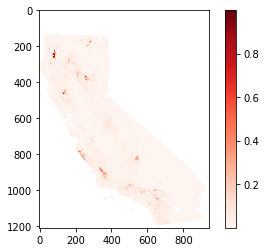

In [27]:
raster_ex = "F:/5year/aet/aet-201201.tif"
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = unmask_concatenated_df_prob_1996.values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

compare to actual

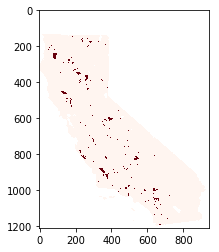

In [32]:

path = r"G:\Fire_target_train\fire_1996_2000.tif"
image_name = tr.image_names(path)
rasters = tr.image_to_array(path)[:,:,0]
rasters[isnan(f2Array)] = NaN

plt.imshow(rasters)
plt.set_cmap("Reds")
plt.show()
